In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'C:\\Users\\Gustavo\\flatiron\\class-material\\section03\\Phase03Project\\Notebooks'

In [9]:
#preparing the data for modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Tuning and getting stats from our models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


#Models/Classifiers we will be using
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

#Final steps
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import StackingClassifier


# Loading data and creating dummies

In [3]:
#Loadin dataset
scrubbed_set = pd.read_csv("../Data/scrubbed_trainingdata.csv")
scrubbed_set.drop(columns= 'Unnamed: 0', inplace=True)

In [4]:
scrubbed_set.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'population',
       'public_meeting', 'permit', 'construction_year',
       'extraction_type_class', 'management', 'payment_type', 'quality_group',
       'quantity', 'source_type', 'waterpoint_type_group', 'status_group',
       'years_since_construction', 'days_since_recorded'],
      dtype='object')

In [12]:
#Assign X features and y target within dataset
scrubbedX = scrubbed_set.drop(columns=['id','date_recorded','construction_year','status_group'])
scrubbedy = scrubbed_set['status_group']

In [13]:
#Pulls all categorical columns within the dataset
categoricals = []
for column in scrubbedX.columns:
    if scrubbedX[column].dtype == 'object':
        categoricals.append(column)
    else:
        continue
#Combines dummy variables and continuous variables back together
dummies = pd.get_dummies(scrubbedX[categoricals], prefix= categoricals, drop_first=True)
scrubbedX_ = scrubbedX.drop(columns = categoricals)
scrubbedX_ = pd.concat([scrubbedX_, dummies], axis=1)
scrubbedX_.head(10)

,amount_tsh,gps_height,longitude,latitude,population,public_meeting,permit,years_since_construction,days_since_recorded,funder_Government Of Tanzania,...,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,6000.0,1390,34.938093,-9.856322,109,1.0,0.0,14.0,995,0,...,0,0,0,0,1,1,0,0,0,0
1,0.0,1399,34.698766,-2.147466,280,1.0,1.0,3.0,272,0,...,0,1,0,0,0,1,0,0,0,0
2,25.0,686,37.460664,-3.821329,250,1.0,1.0,4.0,281,0,...,0,0,0,0,0,1,0,0,0,0
3,0.0,263,38.486161,-11.155298,58,1.0,1.0,27.0,309,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,0,31.130847,-1.825359,0,1.0,1.0,17.0,874,0,...,0,1,0,0,0,1,0,0,0,0
5,20.0,0,39.172796,-4.765587,1,1.0,1.0,4.0,996,0,...,1,0,0,0,0,1,0,0,0,0
6,0.0,0,33.362410,-3.766365,0,1.0,1.0,17.0,428,0,...,0,0,0,0,0,0,0,1,0,0
7,0.0,0,32.620617,-4.226198,0,1.0,1.0,17.0,420,0,...,0,0,0,1,0,0,0,1,0,0
8,0.0,0,32.711100,-5.146712,0,1.0,1.0,17.0,395,0,...,0,0,0,0,0,0,0,1,0,0
9,0.0,0,30.626991,-1.257051,0,1.0,1.0,17.0,853,0,...,0,0,0,1,0,0,0,1,0,0


### Split the data

In [14]:
#Splits data into train and test sets
sX_train, sX_test, sy_train, sy_test = train_test_split(scrubbedX_, scrubbedy)

## Random Forest Classifier

In [15]:
forest = RandomForestClassifier()

In [278]:
#Parameter grid for random forest for gridsearchCV
rf_param_grid = {'n_estimators': [100,1000, 500],\
                'criterion': ['gini','entropy'],\
                'max_depth': [ None, 10, 15],\
                'min_samples_split': [2, 5],\
                'min_samples_leaf': [2, 3]}

gs_tree = GridSearchCV(forest, rf_param_grid, cv=3)

gs_tree.fit(sX_train, sy_train)
print(gs_tree.best_params_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}


In [17]:
forest = RandomForestClassifier(n_estimators=500, criterion='gini', 
                                max_depth=None, min_samples_split=5, min_samples_leaf=2)

#Train data on the model
forest.fit(sX_train, sy_train)

#Predictions for the training and test set
forest_train_preds = forest.predict(sX_train)
forest_test_preds = forest.predict(sX_test)

#Create Classification Result
train_accuracy_forest = accuracy_score(sy_train, forest_train_preds)
test_accuracy_forest = accuracy_score(sy_test, forest_test_preds)
report_forest = classification_report(sy_test, forest_test_preds)


print("Random Forest")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_forest * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_forest * 100):.4}%")

# append accuracy score to our dataframe
score_forest = ['Random Forest', train_accuracy_forest, test_accuracy_forest]

Random Forest
-------------------------
Training Accuracy: 89.64%
Test Accuracy:     80.59%


In [18]:
print(report_forest)

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      8046
functional needs repair       0.67      0.25      0.36      1133
         non functional       0.84      0.77      0.80      5671

               accuracy                           0.81     14850
              macro avg       0.77      0.64      0.67     14850
           weighted avg       0.80      0.81      0.79     14850



The highest precision is on the nonfunctional wells and have been able to recall 91% of the functional wells. The f-1 score is 0.85, which also means this model performs pretty well overall. There is a class imbalance with 'functional needs repair' class having significantly fewer than the others, this is reflected in the model by the low recall on said class. The percentage difference between the training accuracy and the test accuracy suggests some overfitting on the training data.

_________________________________________

## XGBoost Classifier

In [19]:
xgbooster = XGBClassifier()

In [227]:
xgb_param_grid = {'n_estimators': [100, 200],\
                 'learning_rate': [ 0.05, 0.1],\
                 'max_depth': [6,7],\
                 'gamma': [0.0, 0.1, 0.2]}

gs_boost = GridSearchCV(xgbooster, xgb_param_grid, scoring='accuracy', cv=3)

gs_boost.fit(sX_train, sy_train)
print(gs_boost.best_params_)

{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [22]:
xgbooster = XGBClassifier(n_estimators= 200,learning_rate= 0.1, max_depth= 7,\
                         gamma= 0.2)

#Train data on the model
xgbooster.fit(sX_train, sy_train)

#Predictions for the training and test set
xgbooster_train_preds = xgbooster.predict(sX_train)
xgbooster_test_preds = xgbooster.predict(sX_test)

#Create Classification Result
train_accuracy_xgbooster = accuracy_score(sy_train, xgbooster_train_preds)
test_accuracy_xgbooster = accuracy_score(sy_test, xgbooster_test_preds)
report_xgbooster = classification_report(sy_test, xgbooster_test_preds)

print("XGBoost")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_xgbooster * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_xgbooster * 100):.4}%")

XGBoost
-------------------------
Training Accuracy: 84.46%
Test Accuracy:     79.6%


In [23]:
print(report_xgbooster)

                         precision    recall  f1-score   support

             functional       0.78      0.91      0.84      8046
functional needs repair       0.65      0.22      0.33      1133
         non functional       0.85      0.74      0.79      5671

               accuracy                           0.80     14850
              macro avg       0.76      0.63      0.65     14850
           weighted avg       0.79      0.80      0.78     14850



Scores across the board are either just as good if not slightly worse when compared to the random forest model. Once again there is a low recall for the minority class of 'functional needs repair'. There is a very slight improvement in precision and f1 score for the non functional class in this model. Overall accuracy seems good as well with 79.6%. The training accuracy and test accuracy have a near 5% difference, which could suggest some slight overfitting on the training data.

________________________________

### Scaling the data for KNN and Logistic Regression

In [29]:
#Scaler to use
scaler = MinMaxScaler()

#ssX = scaled, scrubbed X
ssX_train = scaler.fit_transform(sX_train)
ssX_test = scaler.transform(sX_test)

_________________________________

## KNN Classifier

In [30]:
knn = KNeighborsClassifier()

In [235]:
knn_param_grid = {'n_neighbors': [3, 5, 8, 10],\
                 'weights': ['uniform','distance']}

gs_knn = GridSearchCV(knn, knn_param_grid, scoring= 'accuracy', cv= 3)

gs_knn.fit(ssX_train, sy_train)
print(gs_knn.best_params_)

{'n_neighbors': 8, 'weights': 'distance'}


In [31]:
knn = KNeighborsClassifier(n_neighbors= 8 , weights= 'distance' )

#Train data on the model
knn.fit(ssX_train, sy_train)

#Predictions for the training and test set
knn_train_preds = knn.predict(ssX_train)
knn_test_preds = knn.predict(ssX_test)

#Create Classification Result
train_accuracy_knn = accuracy_score(sy_train, knn_train_preds)
test_accuracy_knn = accuracy_score(sy_test, knn_test_preds)
report_knn = classification_report(sy_test, knn_test_preds)

print("K-Nearest Neighbors")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_knn * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_knn * 100):.4}%")

K-Nearest Neighbors
-------------------------
Training Accuracy: 99.82%
Test Accuracy:     77.82%


In [32]:
print(report_knn)

                         precision    recall  f1-score   support

             functional       0.79      0.85      0.82      8046
functional needs repair       0.46      0.31      0.37      1133
         non functional       0.80      0.76      0.78      5671

               accuracy                           0.78     14850
              macro avg       0.68      0.64      0.66     14850
           weighted avg       0.77      0.78      0.77     14850



th this model there is a noticeable increase in the recall of the minority class 'functional needs repair' as compared to our previous two models. However, this model is most definitely overfitted to the training data, with a 99.82% accuracy on training data and a 77.82% accuracy on the test. that is a 22% difference! This model was 2.77% less accurate than the random forest model.

_________________________________

## Logistic Regression Classifier

In [253]:
logreg = LogisticRegression(multi_class= 'multinomial')

In [255]:
logreg_param_grid = {'fit_intercept':[True, False],\
                    'solver': ['sag','saga'],\
                    'max_iter': [100, 150]}

gs_logreg = GridSearchCV(logreg, logreg_param_grid, scoring= 'accuracy', cv=3)

gs_logreg.fit(ssX_train, sy_train)
print(gs_logreg.best_params_)

C:\Users\Gustavo\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Gustavo\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

{'fit_intercept': True, 'max_iter': 100, 'solver': 'sag'}


C:\Users\Gustavo\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [74]:
logreg = LogisticRegression(multi_class= 'multinomial', fit_intercept= True,\
                           solver= 'sag' , max_iter= 100 )

#Train data on the model
logreg.fit(ssX_train, sy_train)

#Predictions for the training and test set
logreg_train_preds = logreg.predict(ssX_train)
logreg_test_preds = logreg.predict(ssX_test)

#Create Classification Result
train_accuracy_logreg = accuracy_score(sy_train, logreg_train_preds)
test_accuracy_logreg = accuracy_score(sy_test, logreg_test_preds)
report_logreg = classification_report(sy_test, logreg_test_preds)

print("Logistic Regression")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_logreg * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_logreg * 100):.4}%")

Logistic Regression
-------------------------
Training Accuracy: 73.55%
Test Accuracy:     73.52%


In [34]:
print(report_logreg)

                         precision    recall  f1-score   support

             functional       0.72      0.90      0.80      8046
functional needs repair       0.47      0.05      0.10      1133
         non functional       0.78      0.64      0.71      5671

               accuracy                           0.74     14850
              macro avg       0.66      0.53      0.53     14850
           weighted avg       0.72      0.74      0.71     14850



Logistic Regression is the weakest model showcased by far. It has the lowest accuracy on the training and testing data, as well as the least recall on the minority class by a significant margin and lower scores in all other metrics as well. It is, however, well-fit. The training and test accuracies are remarkably close to one another.

____________________________________

## Dealing with class imbalance with SMOTE
Since I have major class imbalance in the dataset, I will use smote to synthetically resample from the scrubbed dataset. I will then rerun the models to compare the accuracy differences between the smoted and non smoted sets.

In [35]:
smote = SMOTE()

In [36]:
#sms = smoted, scrubbed
#using smote on dataset
smsX_train, smsy_train = smote.fit_sample(sX_train, sy_train)

#All column names are put into an array
training_column_names = sX_train.columns

#Smoted X_train is put in a dataframe just like sX_train
smsX_train = pd.DataFrame(smsX_train, columns= training_column_names)

#Value counts of target group before smote
print(sy_train.value_counts(), '\n')
#Value counts of target group after smote
print(pd.Series(smsy_train).value_counts())

#Will use '_' at the end to denote that these were done with smote

functional                 24213
non functional             17153
functional needs repair     3184
Name: status_group, dtype: int64 

non functional             24213
functional                 24213
functional needs repair    24213
dtype: int64


smoted only the training set so that I may test it against our test set.

_____________________________________

## Random Forest Classifier (SMOTE)

In [37]:
forest_ = RandomForestClassifier(n_estimators=500, criterion='gini', 
                                max_depth=None, min_samples_split=5, min_samples_leaf=2)

#Train data on the model
forest_.fit(smsX_train, smsy_train)

#Predictions for the training and test set
forest_train_preds_ = forest_.predict(smsX_train)
forest_test_preds_ = forest_.predict(sX_test)

#Create Classification Result
train_accuracy_forest_ = accuracy_score(smsy_train, forest_train_preds_)
test_accuracy_forest_ = accuracy_score(sy_test, forest_test_preds_)
report_forest_ = classification_report(sy_test, forest_test_preds_)


print("Random Forest (SMOTED)")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_forest_ * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_forest_ * 100):.4}%")

# append accuracy score to our dataframe
score_forest = ['Random Forest', train_accuracy_forest, test_accuracy_forest]

Random Forest (SMOTED)
-------------------------
Training Accuracy: 93.88%
Test Accuracy:     79.69%


In [38]:
print(report_forest_)

                         precision    recall  f1-score   support

             functional       0.81      0.86      0.84      8046
functional needs repair       0.46      0.42      0.44      1133
         non functional       0.83      0.78      0.81      5671

               accuracy                           0.80     14850
              macro avg       0.70      0.69      0.69     14850
           weighted avg       0.79      0.80      0.80     14850



In [70]:
#Prints the confusion matrices for our smoted and non smoted classifier
#without smote
print(confusion_matrix(sy_test, forest_test_preds),'\n')
#with smote
print("Smoted \n",confusion_matrix(sy_test, forest_test_preds_), '\n')

[[7331   92  623]
 [ 660  278  195]
 [1266   47 4358]] 

Smoted 
 [[6925  406  715]
 [ 495  473  165]
 [1092  143 4436]] 



It appears as if SMOTE has caused our model to overfit more onto the training data as the Training Accuracy hs increased while Test Accuracy decreased. Recall on the minority class has increased at the expense of some precision, however the f1 score has improved, signaling that overall SMOTE-ing has increased the random forest's ability to classify the minority class. Accuracy overall has dropped by less than 1%. It appears the model is paying in accuracy of identifying the 'functional' class correctly for identifying a greater portion of the minority classes.

_________________________________________

## XGBoost Classifier (SMOTE)

In [39]:
xgbooster_ = XGBClassifier(n_estimators= 200,learning_rate= 0.1, max_depth= 7,\
                         gamma= 0.2)

#Train data on the model
xgbooster_.fit(smsX_train, smsy_train)

#Predictions for the training and test set
xgbooster_train_preds_ = xgbooster_.predict(smsX_train)
xgbooster_test_preds_ = xgbooster_.predict(sX_test)

#Create Classification Result
train_accuracy_xgbooster_ = accuracy_score(smsy_train, xgbooster_train_preds_)
test_accuracy_xgbooster_ = accuracy_score(sy_test, xgbooster_test_preds_)
report_xgbooster_ = classification_report(sy_test, xgbooster_test_preds_)

print("XGBoost (SMOTED)")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_xgbooster_ * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_xgbooster_ * 100):.4}%")

XGBoost (SMOTED)
-------------------------
Training Accuracy: 87.9%
Test Accuracy:     77.89%


In [40]:
print(report_xgbooster_)

                         precision    recall  f1-score   support

             functional       0.79      0.85      0.82      8046
functional needs repair       0.42      0.41      0.42      1133
         non functional       0.84      0.74      0.79      5671

               accuracy                           0.78     14850
              macro avg       0.68      0.67      0.68     14850
           weighted avg       0.78      0.78      0.78     14850



In [71]:
#Prints the confusion matrices for our smoted and non smoted classifier
#without smote
print(confusion_matrix(sy_test, xgbooster_test_preds),'\n')
#with smote
print("Smoted \n",confusion_matrix(sy_test, xgbooster_test_preds_), '\n')

[[7355   93  598]
 [ 708  251  174]
 [1417   40 4214]] 

Smoted 
 [[6876  506  664]
 [ 513  469  151]
 [1298  152 4221]] 



Similar occurance in what happend to our random forest has happened in our xgboost classifier. Training accuracy has increased by a noticeable portion while test accuracy has dropped minimally. There is increased recall  and f1 score for the minority class. The decrease in accuracy could be a result of overfitting as caused by SMOTE-ing the training data. Similar to the random forest, this model is less accurately able to classify the 'funcitonal' class while more correctly able to classify the minority classes.

______________________________________________

## K-Nearest Neighbors (SMOTE)

In [41]:
#Creating pipeline that will scale the smoted data and then run the knn classifier
knn_pipeline = Pipeline([('mm', MinMaxScaler()),
                             ('knn', KNeighborsClassifier(n_neighbors= 8 , weights= 'distance' ))])

#fitting pipeline to smoted data
knn_pipeline.fit(smsX_train, smsy_train)

Pipeline(steps=[('mm', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=8, weights='distance'))])

In [61]:
#Predictions for the training and test set
knn_pipeline_train_preds = knn_pipeline.predict(smsX_train)
knn_pipeline_test_preds = knn_pipeline.predict(sX_test)

#Create Classification Result
train_accuracy_knn_ = accuracy_score(smsy_train, knn_pipeline_train_preds)
test_accuracy_knn_ = accuracy_score(sy_test, knn_pipeline_test_preds)
report_knn_ = classification_report(sy_test, knn_pipeline_test_preds)

print("K-Nearest Neighbors (SMOTED)")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_knn_ * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_knn_ * 100):.4}%")

K-Nearest Neighbors (SMOTED)
-------------------------
Training Accuracy: 99.88%
Test Accuracy:     75.59%


In [43]:
print(report_knn_)

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.80      8046
functional needs repair       0.32      0.43      0.37      1133
         non functional       0.80      0.76      0.78      5671

               accuracy                           0.76     14850
              macro avg       0.64      0.66      0.65     14850
           weighted avg       0.77      0.76      0.76     14850



In [72]:
#Prints the confusion matrices for our smoted and non smoted classifier
#without smote
print(confusion_matrix(sy_test, knn_test_preds),'\n')
#with smote
print("Smoted \n",confusion_matrix(sy_test, knn_pipeline_test_preds), '\n')

[[6867  283  896]
 [ 579  354  200]
 [1205  130 4336]] 

Smoted 
 [[6403  705  938]
 [ 469  492  172]
 [1015  326 4330]] 



The trend continues with the K-nearest neighbors model. The model is has an increased training accuracy with a decreased test accuracy. In this model however there are less points in the 'non functional' class that were classified correctly, but only 6. More points were classified correctly in the 'functional needs repair' class.

___________________________________

## Logistic Regression (SMOTE)

In [77]:
logreg_pipeline = Pipeline([('mm', MinMaxScaler()),
                             ('logr', LogisticRegression(multi_class= 'multinomial', fit_intercept= True,\
                           solver= 'sag' , max_iter= 100 ))])

logreg_pipeline.fit(smsX_train, smsy_train)

Pipeline(steps=[('mm', MinMaxScaler()),
                ('logr',
                 LogisticRegression(multi_class='multinomial', solver='sag'))])

In [78]:
#Predictions for the training and test set
logreg_pipeline_train_preds = logreg_pipeline.predict(smsX_train)
logreg_pipeline_test_preds = logreg_pipeline.predict(sX_test)

#Create Classification Result
train_accuracy_logreg_ = accuracy_score(smsy_train, logreg_pipeline_train_preds)
test_accuracy_logreg_ = accuracy_score(sy_test, logreg_pipeline_test_preds)
report_logreg_ = classification_report(sy_test, logreg_pipeline_test_preds)

print("Logistic Regression (SMOTED)")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_logreg_ * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_logreg_ * 100):.4}%")

Logistic Regression (SMOTED)
-------------------------
Training Accuracy: 65.23%
Test Accuracy:     63.16%


In [54]:
print(report_logreg_)

                         precision    recall  f1-score   support

             functional       0.78      0.63      0.70      8046
functional needs repair       0.19      0.64      0.30      1133
         non functional       0.78      0.63      0.70      5671

               accuracy                           0.63     14850
              macro avg       0.58      0.63      0.56     14850
           weighted avg       0.73      0.63      0.67     14850



In [79]:
#Prints the confusion matrices for our smoted and non smoted classifier
#without smote
print(confusion_matrix(sy_test, logreg_test_preds),'\n')
#with smote
print("Smoted \n",confusion_matrix(sy_test, logreg_pipeline_test_preds), '\n')

[[7219   30  797]
 [ 870   61  202]
 [1994   40 3637]] 

Smoted 
 [[5083 2111  852]
 [ 276  721  136]
 [1194  902 3575]] 



Training and test accuracy have dropped considerably between the before and after smote logistic regression classifiers. Logistic regression with smote did, however, correctly identify the highest amount of the minority class and experienced the greatest difference in recall before and after smote for said minority class. The accuracy has dropped considerably, most likely due to the plentiful misclassification of the majority class.

___________________________________________________

## Selecting Final Model

Random Forest seemed to have the highest accuracy score, but let us view it in comparison to our other models

In [83]:
test_accuracies_dict = {'Model': ['Random Forest','Random Forest','XGBoost','XGBoost',\
                                  'KNN','KNN','Logistic Regression','Logistic Regression'],\
                       'Accuracy':[test_accuracy_forest, test_accuracy_forest_, test_accuracy_xgbooster, test_accuracy_xgbooster_,\
                                  test_accuracy_knn, test_accuracy_knn_, test_accuracy_logreg, test_accuracy_logreg_],\
                       'SMOTE':['Without SMOTE','SMOTE','Without SMOTE','SMOTE','Without SMOTE','SMOTE','Without SMOTE','SMOTE']}

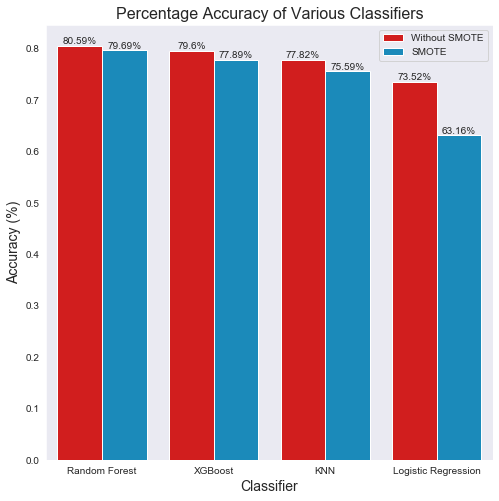

In [168]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=test_accuracies_dict, x='Model', y='Accuracy',\
                hue='SMOTE', palette=['#EF0000','#0094D5'])

for patch in ax.patches:
    x = patch.get_bbox().get_points()[:,0]
    y = patch.get_bbox().get_points()[1,1]
    ax.annotate("{}%".format(round(100*patch.get_height(),2)), (x.mean(), y),\
               ha= 'center', va= 'bottom', fontsize= 'medium') #sets text alignment
    
    
ax.set_title("Percentage Accuracy of Various Classifiers",fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize= 14)
ax.set_xlabel("Classifier", fontsize=14)

plt.show()

In [178]:
def plot_feature_importances(model, model_name, num_of_features= 'all'):
    
    #Allows for specification of number of features to show
    if num_of_features == 'all':
        n_features = sX_train.shape[1]
    else:
        n_features= num_of_features
        
    plt.figure(figsize=(12,8))
    
    #Creates a list of dictionaries of features and their importance
    features_list = []
    for feature, feature_importance in zip(sX_train.columns.values, model.feature_importances_):
        features_list.append({'Feature':feature, 'Feature Importance':feature_importance})
    
    #Creates a dataframe for easier time plotting. df is sorted with most important features at the top
    feature_df = pd.DataFrame(sorted(features_list, key=lambda i: i['Feature Importance'], reverse=True))
    
    sns.barplot(data=feature_df[:n_features], x='Feature Importance',y='Feature', orient='h')
    
    plt.title("Feature Importance of {} model".format(model_name), fontsize=16)
    plt.xlabel('Feature importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
sns.set_style('darkgrid')

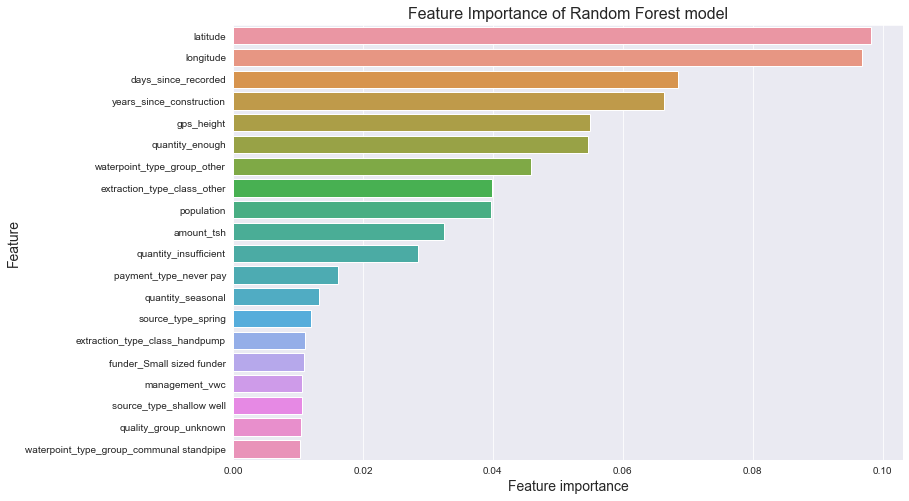

In [179]:
plot_feature_importances(forest, 'Random Forest', 20)

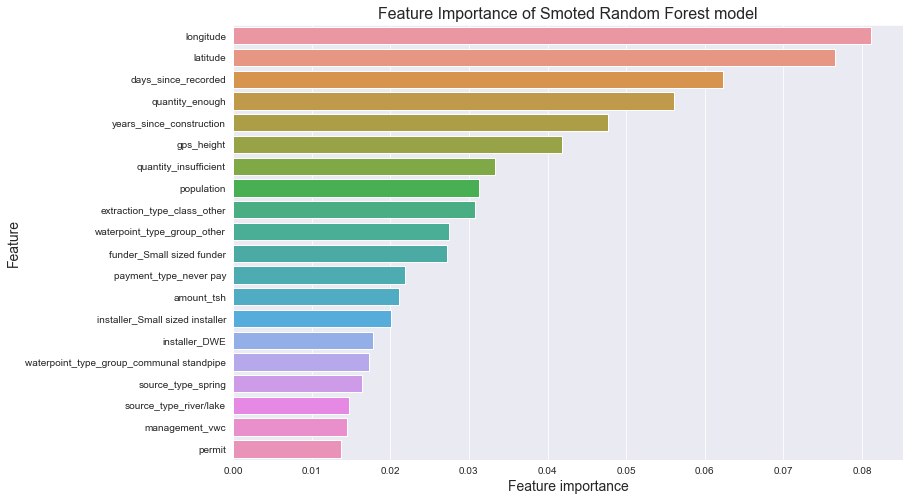

In [180]:
plot_feature_importances(forest_, 'Smoted Random Forest', 20)

Looks like the most important features within the Random Forest model were the longitude and latitude coordinates. Days since record and since construction proved to be important as well.  Certain categories such as quantity-succifient proved to be more useful when we Smoted our dataset and rose in importance. 

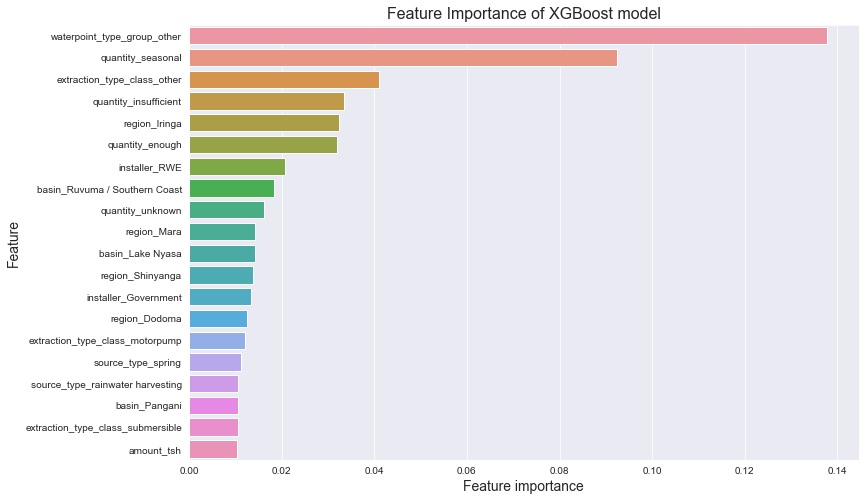

In [181]:
plot_feature_importances(xgbooster, 'XGBoost', 20)

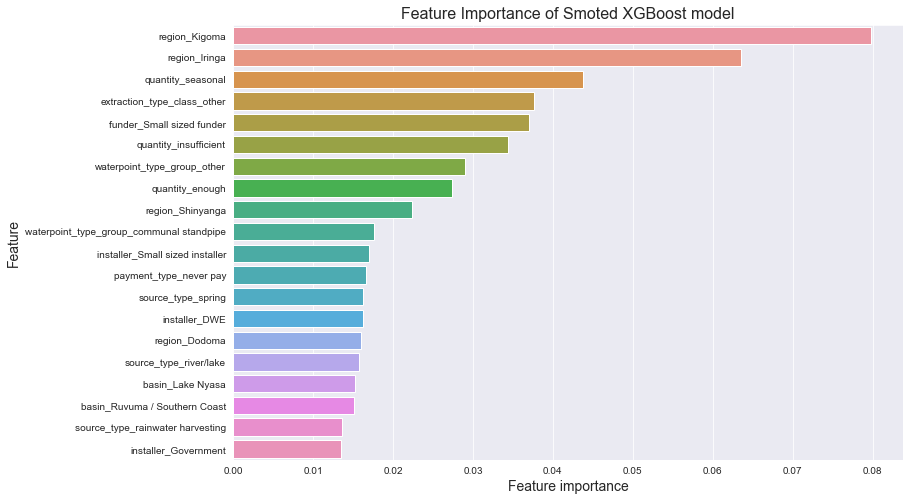

In [182]:
plot_feature_importances(xgbooster_, 'Smoted XGBoost', 20)


Within the XGBoost classifier, extraction type class-other, quantity-seasonal, and waterpoint type group-other appear to be the most important. With the smoted data, different regional identities rise in feature importance, this points to possibly paying more attention to these regions in the future.
# -
feature importances appear better spread after having had smoted the data. The weight of importance is better distributed among features

_____________________________

## Final Test Score
Random Forest gave the best score of all the classifiers, and thus is the classifier I choose. I will use the SMOTED version of the training set, as it picks up more of the minority class.

In [164]:
forest_.score(sX_test, sy_test)

0.7969023569023569